In [21]:
import configparser
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
from binance.client import Client

## The Automatic Correlated Coin List (TACCL)

This script will allow you to build a list of correlated coins around a coin of your choice. You will need: 

1. A binance API Key
2. A chosen Bridge coin (Default USDT)
3. A chosen start coin (Default QUMT)

The script will do the rest. This is not a trading recommendation. Trading is risky, do not trade with money you cannot afford to lose. 

#### Basic strategy: 

This script will gather the data for all coin pairs available for your bridge coin. It will sequentially choose coins that maximise the sum of the correlations. This heuristic should pick a good list of co-related coins. 

## Usage Instructions

Run every line of the script. The final two boxes will display the recommended coin list and the heatmap of the rolling average for the last 24 hours.

In [22]:
def get_ticker_price(ticker_symbol: str, days:int , granularity:str):
    """
    Gets ticker price of a specific coin
    """

    target_date = (datetime.now() -timedelta(days = days)).strftime("%d %b %Y %H:%M:%S")
    key = f"{ticker_symbol}"
    end_date = datetime.now() 
    end_date = end_date.strftime("%d %b %Y %H:%M:%S")
    
    coindata = pd.DataFrame(columns = [key])
    
    prices = []
    dates = []
    for result in client.get_historical_klines(
        ticker_symbol, granularity, target_date, end_date, limit=1000
        ):
        date = datetime.utcfromtimestamp(result[0] / 1000).strftime("%d %b %Y %H:%M:%S")
        price = float(result[1])
        dates.append(date)
        prices.append(price)

    coindata[key] = prices
    coindata['date'] = dates

    return(coindata.reindex(columns =['date',key]))

In [23]:
CFG_FL_NAME = "../user.cfg"
USER_CFG_SECTION = "binance_user_config"
config = configparser.ConfigParser()
config.read(CFG_FL_NAME)

api_key = config.get(USER_CFG_SECTION, "api_key")
api_secret = config.get(USER_CFG_SECTION, "api_secret_key")
client = Client(api_key, api_secret)

print("Client created",client)

Client created <binance.client.Client object at 0x13e9852b0>


In [24]:
def get_price_data(tickers, days = 1, granularity = "1m"):
    '''
    Collects price data from the binance server.
    '''
    failures = []
    coindata = get_ticker_price(tickers[0], days, granularity)
    for tick in tickers[1:]:
        newdata = get_ticker_price(tick, days, granularity)
        if not newdata.empty:
            coindata = coindata.merge(newdata, how ='left')
            
        else:
            failures.append(tick)
    print('The following coins do not have historical data')
    print(failures)
    return(coindata)

In [25]:
def take_rolling_average(coindata):

    RA = pd.DataFrame()

    for column in coindata:
        if column != 'date':
            RA[column] = coindata[column].rolling(window=3).mean()
    return(RA)

In [26]:
def pick_coins(start_ticker , day_corr , week_corr, two_week_corr, n):
    '''
    Takes your starting coin, then sequentially picks the coin that jointly maximises
    the correlation for the whole coin list.
    
    INPUT:
    start_ticker : STR : The ticker for a coin you wish to include in your list
    day_corr     : PD.CORR : daily correlation data
    week_corr    : PD.CORR : Weekly correlation data
    two_week_corr: PD.CORR : bi-weekly correlation data
    n            : INTEGER : number of coins to include in your list.
    '''
    
    coinlist = [start_ticker]
    for i in range(n-1):    
        new_day_corr = day_corr[~day_corr.index.isin(coinlist)]
        new_week_corr = week_corr[~week_corr.index.isin(coinlist)]
        new_two_week_corr = two_week_corr[~two_week_corr.index.isin(coinlist)]
        corrsum = pd.DataFrame()
        for coin in coinlist:
            if corrsum.empty:
                corrsum = new_day_corr[coin] + new_week_corr[coin] + new_two_week_corr[coin]
            else:
                corrsum += new_day_corr[coin] + new_week_corr[coin] + new_two_week_corr[coin]
                
        ind = corrsum.argmax()
        coinlist.append(new_day_corr.index[ind])
    return(coinlist)

In [27]:
## Select your bridge coin

In [28]:
bridge = 'USDT'
startcoin = 'XRP'
take_top=15
size_of_list = 8

exclusion_coins = [] #set(line.strip() for line in open('../supported_coin_list'))
excluded = [coin + 'USDT' for coin in exclusion_coins]

excluded.append('FTMUSDT')
excluded.append('SHIBUSDT')
#excluded.append('BNBUSDT') # its not ok if we end up in bnb
#excluded.remove('BTCUSDT') # its ok if we end up in btc
#excluded.remove('ETHUSDT') # its ok if we end up in eth


## Data Collection  -- Only rerun if you change bridge coin --
This code downloads all the data from Binance for all coin pairs with your bridge. You only need to run this once if you keep the same bridge.

In [29]:
# exchange_info = client.get_exchange_info()
#
# print(exchange_info)
# full_coin_list = []
# for s in exchange_info['symbols']:
#     if s['symbol'].endswith(bridge):
#         full_coin_list.append(s['symbol'][:-4])

In [30]:

import requests
import copy
client = Client(api_key, api_secret)

r = requests.get("https://www.binance.com/exchange-api/v2/public/asset-service/product/get-products")
content = r.json()['data']

usdt_coins = [c for c in content if c['q'] == 'USDT' and c['cs'] is not None and c['c'] is not None]

# usdt_coins = []
# for c in usdt_coins__:
#     print(f's={c["s"]}\t\tcs={c["cs"]}\t\tc={c["c"]}')
#     if float(c['cs']) > 0 and float(c['c']) > 0:
#         usdt_coins.append({
#             's': c['s'],
#             'cs': float(c['cs']),
#             'c': float(c['c'])
#         })

#sorted(usdt_coins, key=lambda c: c['cs'] * c['c'])

usdt_coins.sort(key=lambda c: c['cs'] * float(c['c']), reverse=True)

i = 0
startcoin_usdt = None
for c in usdt_coins:
    if i> take_top and c['s'] == startcoin+'USDT':
        startcoin_usdt = copy.deepcopy(c)
    i += 1

usdt_coins = usdt_coins[:take_top]

if startcoin_usdt is not None:
    usdt_coins.append(startcoin_usdt)

cointickers = []
cointickers_with_rank = {}
i = 1
for c in usdt_coins:
    if c['s'] not in excluded:
        cointickers.append(c['s'])
        cointickers_with_rank[c['s']] = i
    i += 1

'''
# Dow[nload ALL the coinpairs fromins binance

exchange_info = client.get_exchange_info()

full_coin_list = []

# Only keep the pairs to our bridge coin
for s in exchange_info['symbols']:
    if s['symbol'].endswith(bridge):
        full_coin_list.append(s['symbol'][:-4])

# List of words to elimin[ate futures markets coins
forbidden_words = ['DOWN', 'UP', 'BULL', 'BEAR']
for forbidden in forbidden_words:
    full_coin_list = [word for word in full_coin_list if forbidden not in word]

#Alphabetical order because pretty :)
full_coin_list.sort()

# Collect the data for 3 different windows (1 day, 1 week, 2 weeks)
# with granularity (1 minute, 1 hour ,2 hours)

cointickers = [coin + bridge for coin in full_coin_list]

'''

day_data = get_price_data(cointickers, 1, "1m")
week_data = get_price_data(cointickers, 7, "1h")
two_week_data = get_price_data(cointickers, 14, "2h")

## Collect the percentage change for correlation measurements

day_data = day_data[day_data.columns.difference(['date'])].pct_change()
week_data = week_data[week_data.columns.difference(['date'])].pct_change()
two_week_data = two_week_data[two_week_data.columns.difference(['date'])].pct_change()

# Calculate the rolling average (RA3) for all the coins 

RA_day_data = take_rolling_average(day_data)
RA_week_data = take_rolling_average(week_data)
RA_2week_data = take_rolling_average(two_week_data)

# take the correlations of the rolling averages.

day_corr = RA_day_data.corr()
week_corr = RA_week_data.corr()
two_week_corr = RA_2week_data.corr()

/Users/skhan/work/binance-trade-bot/venv/lib/python3.8/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)
/Users/skhan/work/binance-trade-bot/venv/lib/python3.8/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)
/Users/skhan/work/binance-trade-bot/venv/lib/python3.8/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute

The following coins do not have historical data
[]


/Users/skhan/work/binance-trade-bot/venv/lib/python3.8/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)
/Users/skhan/work/binance-trade-bot/venv/lib/python3.8/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)
/Users/skhan/work/binance-trade-bot/venv/lib/python3.8/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute

The following coins do not have historical data
[]


/Users/skhan/work/binance-trade-bot/venv/lib/python3.8/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)
/Users/skhan/work/binance-trade-bot/venv/lib/python3.8/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)
/Users/skhan/work/binance-trade-bot/venv/lib/python3.8/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute

The following coins do not have historical data
[]


# Choose your Starting coin here
We will attempt to find a set of coins that are highly correlated with this coin. The reverse greedy algorithm works on the basis that we will try to find a bunch of coins that are highly correlated (which reduced long term risk) but which have short term noise. 

## Choose Size of list 
This is the number of coins you wish to have in your list.


In [31]:
coinlist = pick_coins(startcoin + bridge, day_corr , week_corr , two_week_corr , size_of_list )

In [32]:
# calculate stds
scaled_day_data = (day_data  / day_data.max())
scaled_week_data = (week_data  / week_data.max()) 
scaled_two_week_data = (two_week_data  / two_week_data.max())

day_std = scaled_day_data.std()
week_std = scaled_week_data.std()
two_week_std = scaled_two_week_data.std()

## Looking for volatility in the coinlist
Volatility in the market can be useful for your strategy, but large overwhelming jumps show an unpredictability (or an underlying cause) you should be wary of and investigate.  

These histograms show the maximum jumps taken over a day period (checked per minute) and two weeks (checked per hour). If a coin shows huge volatility you may choose to exclude it from your coin list

Top 10 daily maximum jumps
XRPUSDT      0.010536
AVAXUSDT     0.008310
ADAUSDT      0.008133
MATICUSDT    0.007768
SOLUSDT      0.007639
BTCUSDT      0.005237
ETHUSDT      0.004714
BNBUSDT      0.004099
dtype: float64
Top 10 two weekly maximum jumps
XRPUSDT      0.082811
BNBUSDT      0.070808
SOLUSDT      0.070323
AVAXUSDT     0.064013
MATICUSDT    0.063088
ADAUSDT      0.057385
ETHUSDT      0.056433
BTCUSDT      0.048417
dtype: float64


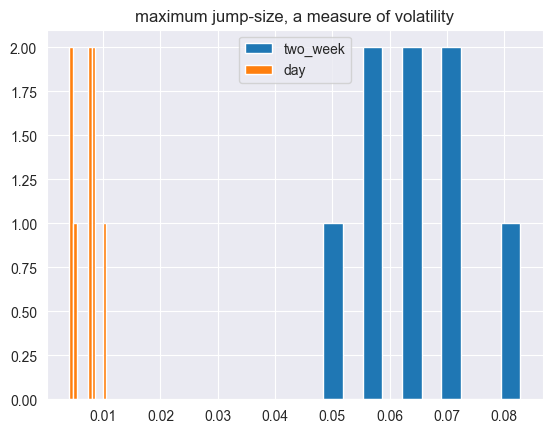

In [33]:
maxjumpday = day_data.max() - day_data.min()
maxjumptwoweek = two_week_data.max() - two_week_data.min()
maxjumptwoweek[coinlist].hist(label='two_week')
maxjumpday[coinlist].hist(label='day')
plt.title('maximum jump-size, a measure of volatility')
plt.legend()
print('Top 10 daily maximum jumps')
print(maxjumpday[coinlist].sort_values(ascending=False)[-8:])
print('Top 10 two weekly maximum jumps')
print(maxjumptwoweek[coinlist].sort_values(ascending=False)[-8:])

# TACCL result: 

This list is not a recommended trading list. Do not risk money if you are not sure what you are doing. 

In [34]:
coins = [coin.replace(bridge,'') for coin in coinlist]
for c in coins:
    print(c)

coins_to_write = [coin.replace(bridge,'\n') for coin in coinlist]

with open("./auto_coins_list", "w") as f:
    f.writelines(coins_to_write)

XRP
ADA
AVAX
SOL
MATIC
ETH
BTC
BNB


In [35]:
coins_to_gain = {}
for coin in coins:
    if cointickers_with_rank[coin + "USDT"] > 8:
        coins_to_gain[coin] = 0.025
    elif cointickers_with_rank[coin + "USDT"] > 4:
        coins_to_gain[coin] = 0.07
    else:
        coins_to_gain[coin] = 0.15
    print(f'{coin} -> {cointickers_with_rank[coin + "USDT"]}, gain : {coins_to_gain[coin]}')
str = 'coins_to_gain = '
for c in coins_to_gain:
    str += f'{c}:{coins_to_gain[c]}, '
with open("./coins_to_gain", "w") as f:
    f.writelines(str)

XRP -> 5, gain : 0.07
ADA -> 7, gain : 0.07
AVAX -> 15, gain : 0.025
SOL -> 8, gain : 0.07
MATIC -> 10, gain : 0.025
ETH -> 3, gain : 0.15
BTC -> 2, gain : 0.15
BNB -> 4, gain : 0.15


The rest of the code will plot the correlation matric for the rolling average of the selected coins.

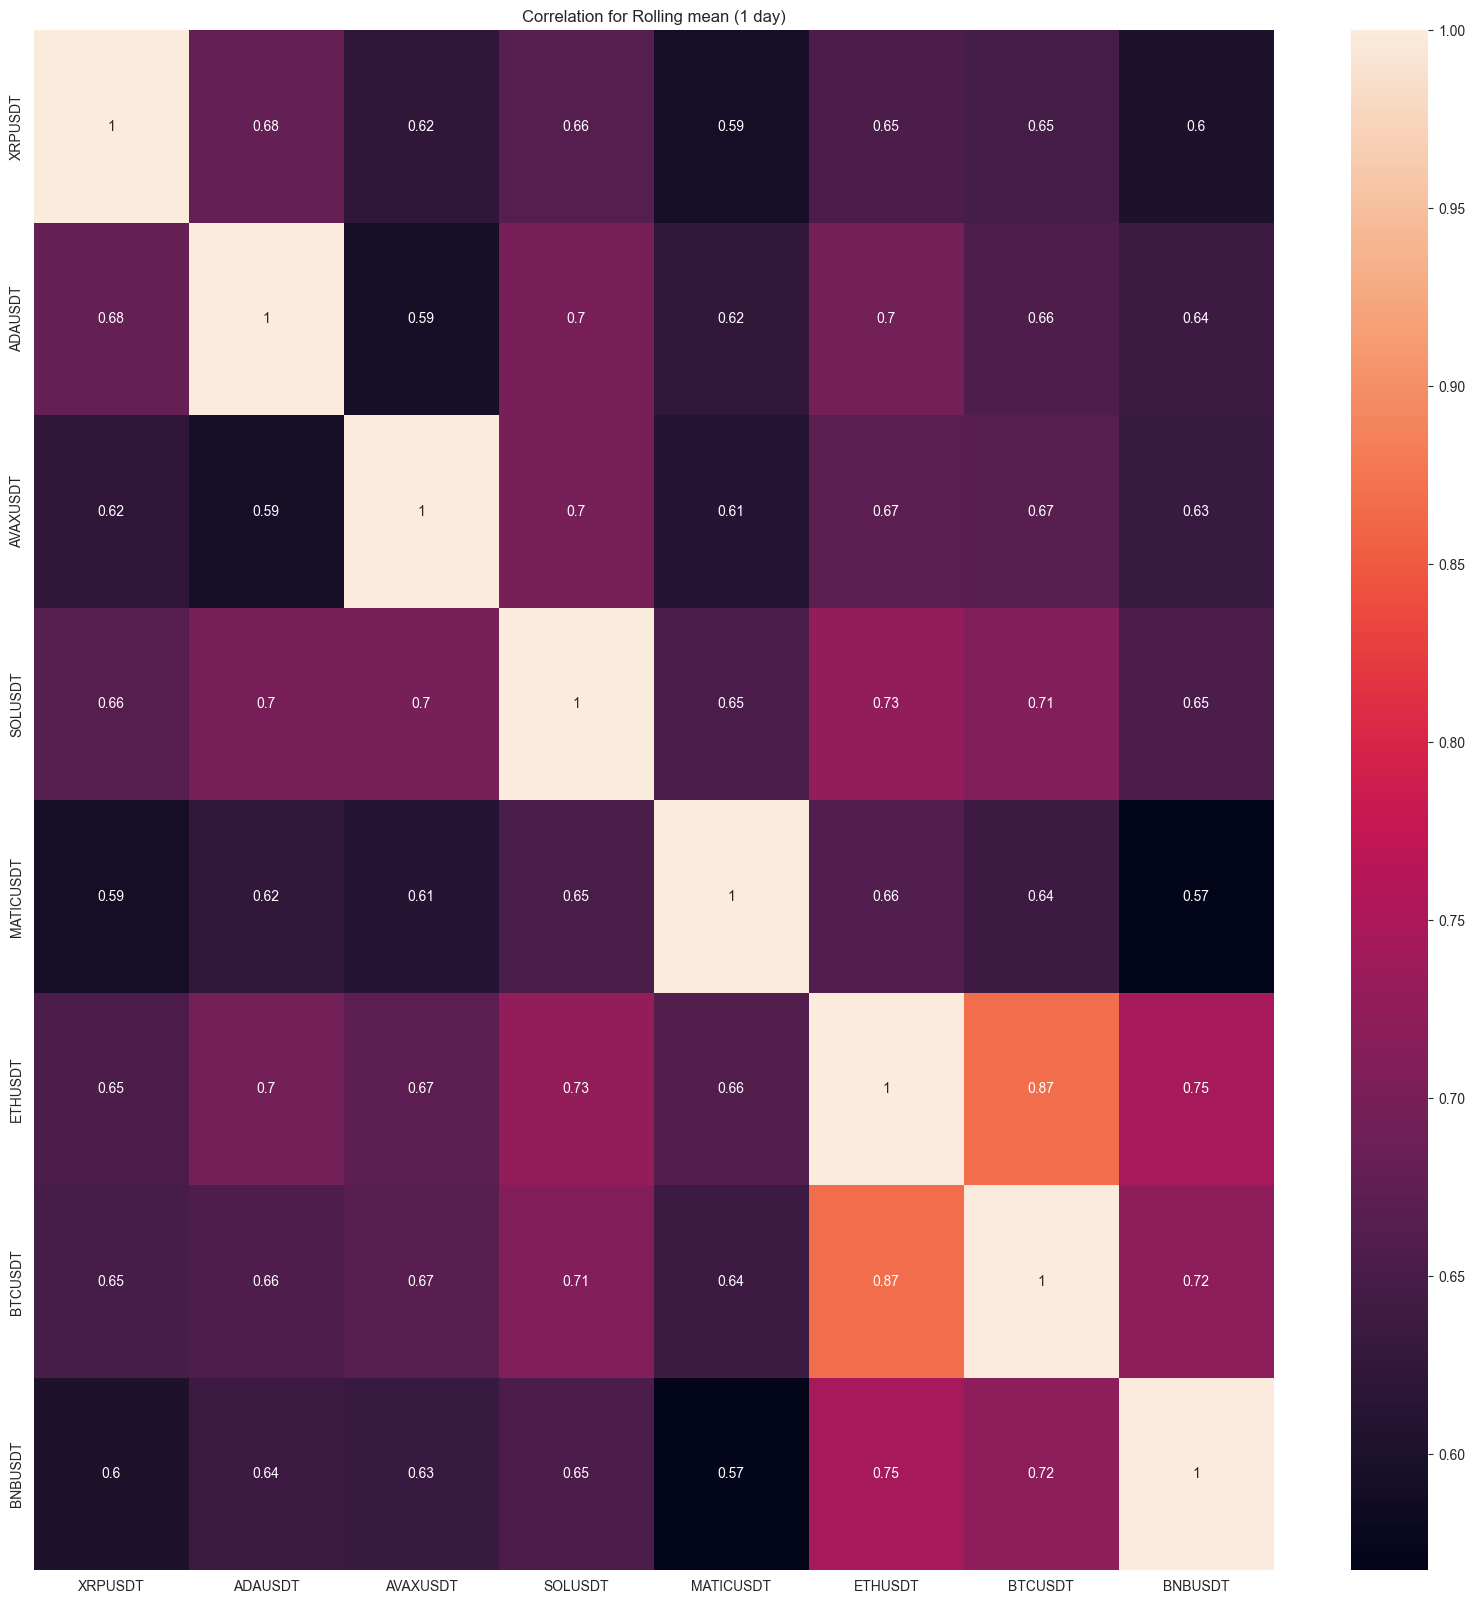

In [36]:
### Examine the trend of the rolling average
corrMatrixday = day_corr[coinlist].loc[coinlist]
fig = plt.figure(figsize=(20,20))
sn.heatmap(corrMatrixday, annot=True)
plt.title('Correlation for Rolling mean (1 day)')
plt.show()

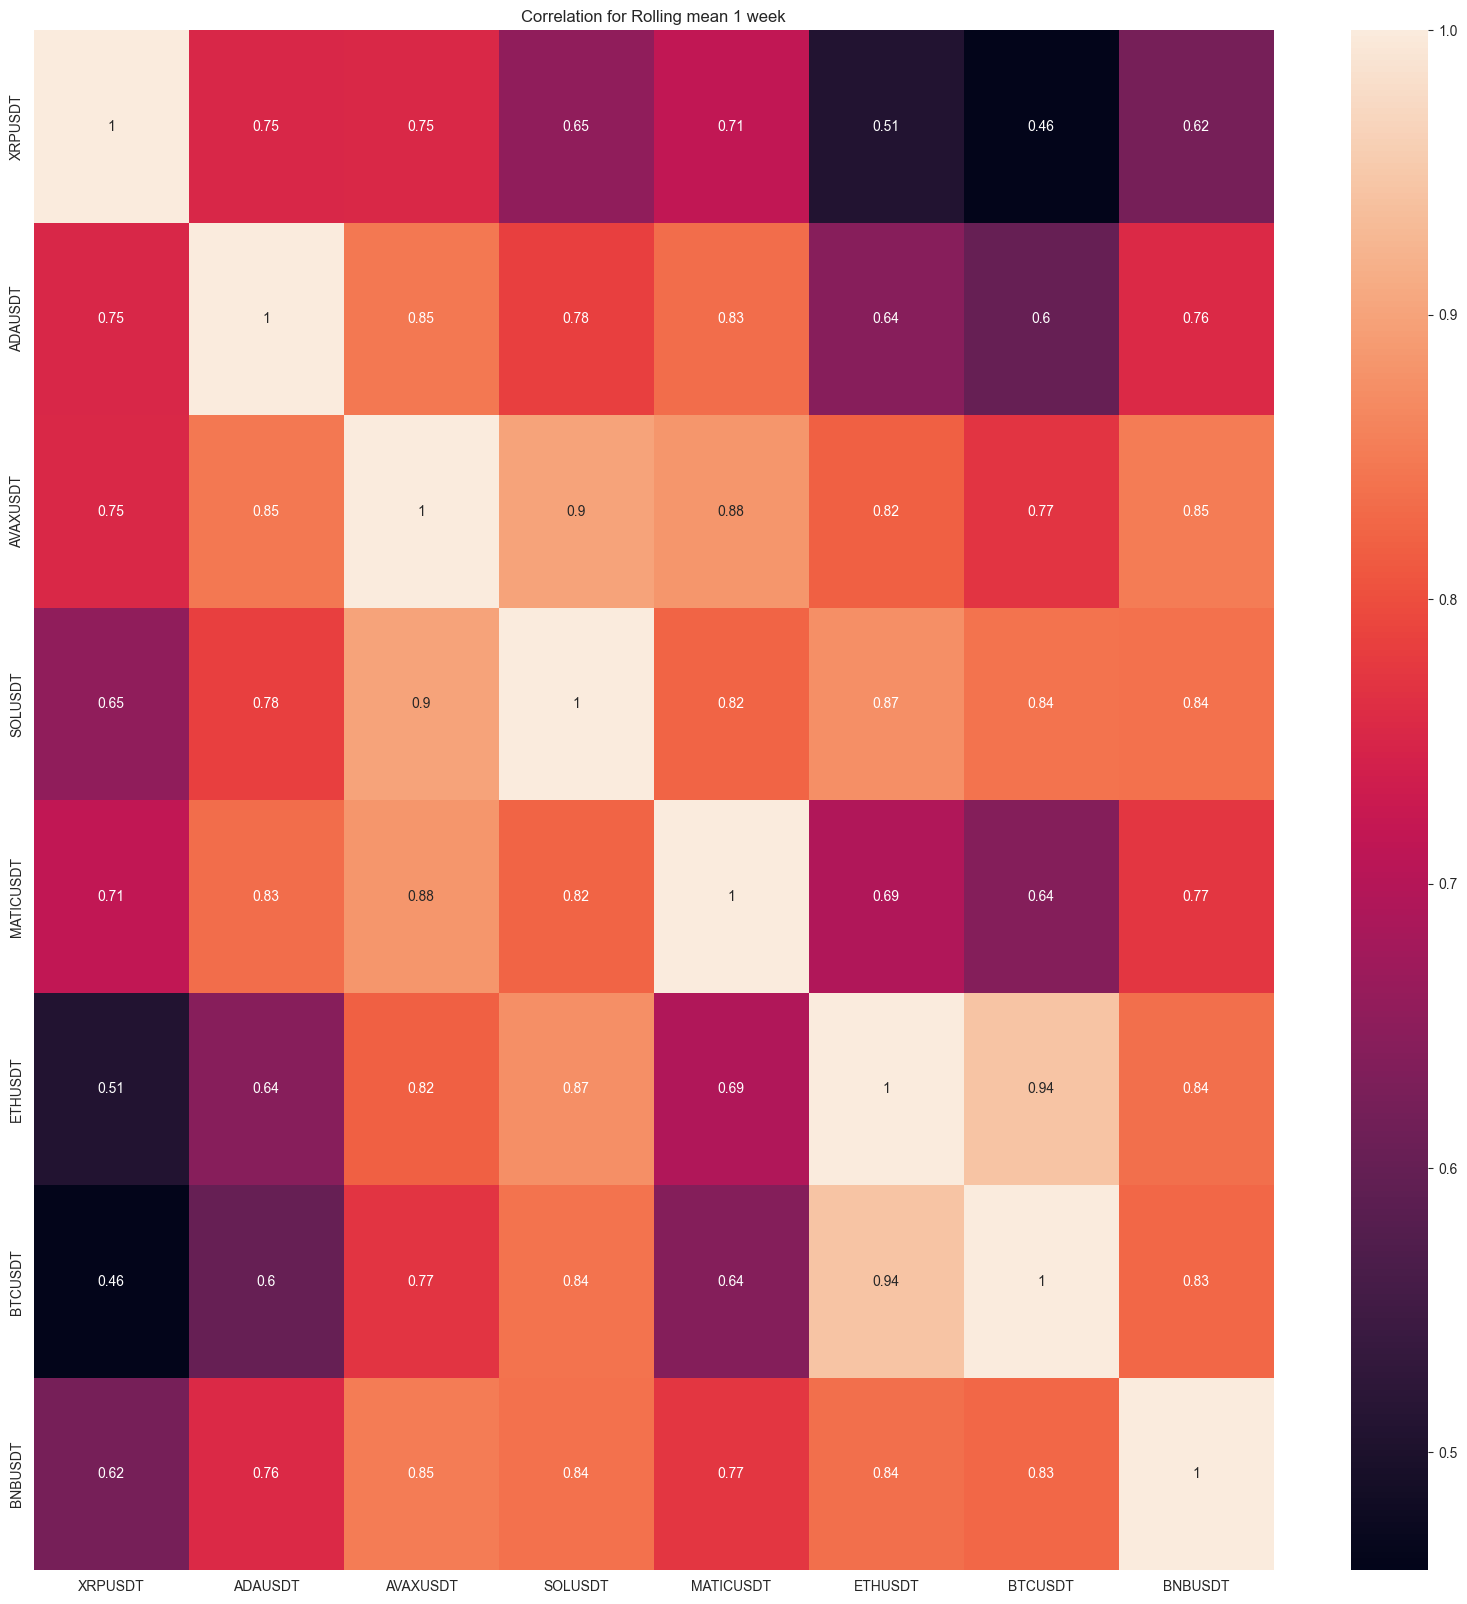

In [37]:
### Examine the trend of the rolling average
corrMatrixweek = week_corr[coinlist].loc[coinlist]
fig = plt.figure(figsize=(20,20))
sn.heatmap(corrMatrixweek, annot=True)
plt.title('Correlation for Rolling mean 1 week')
plt.show()

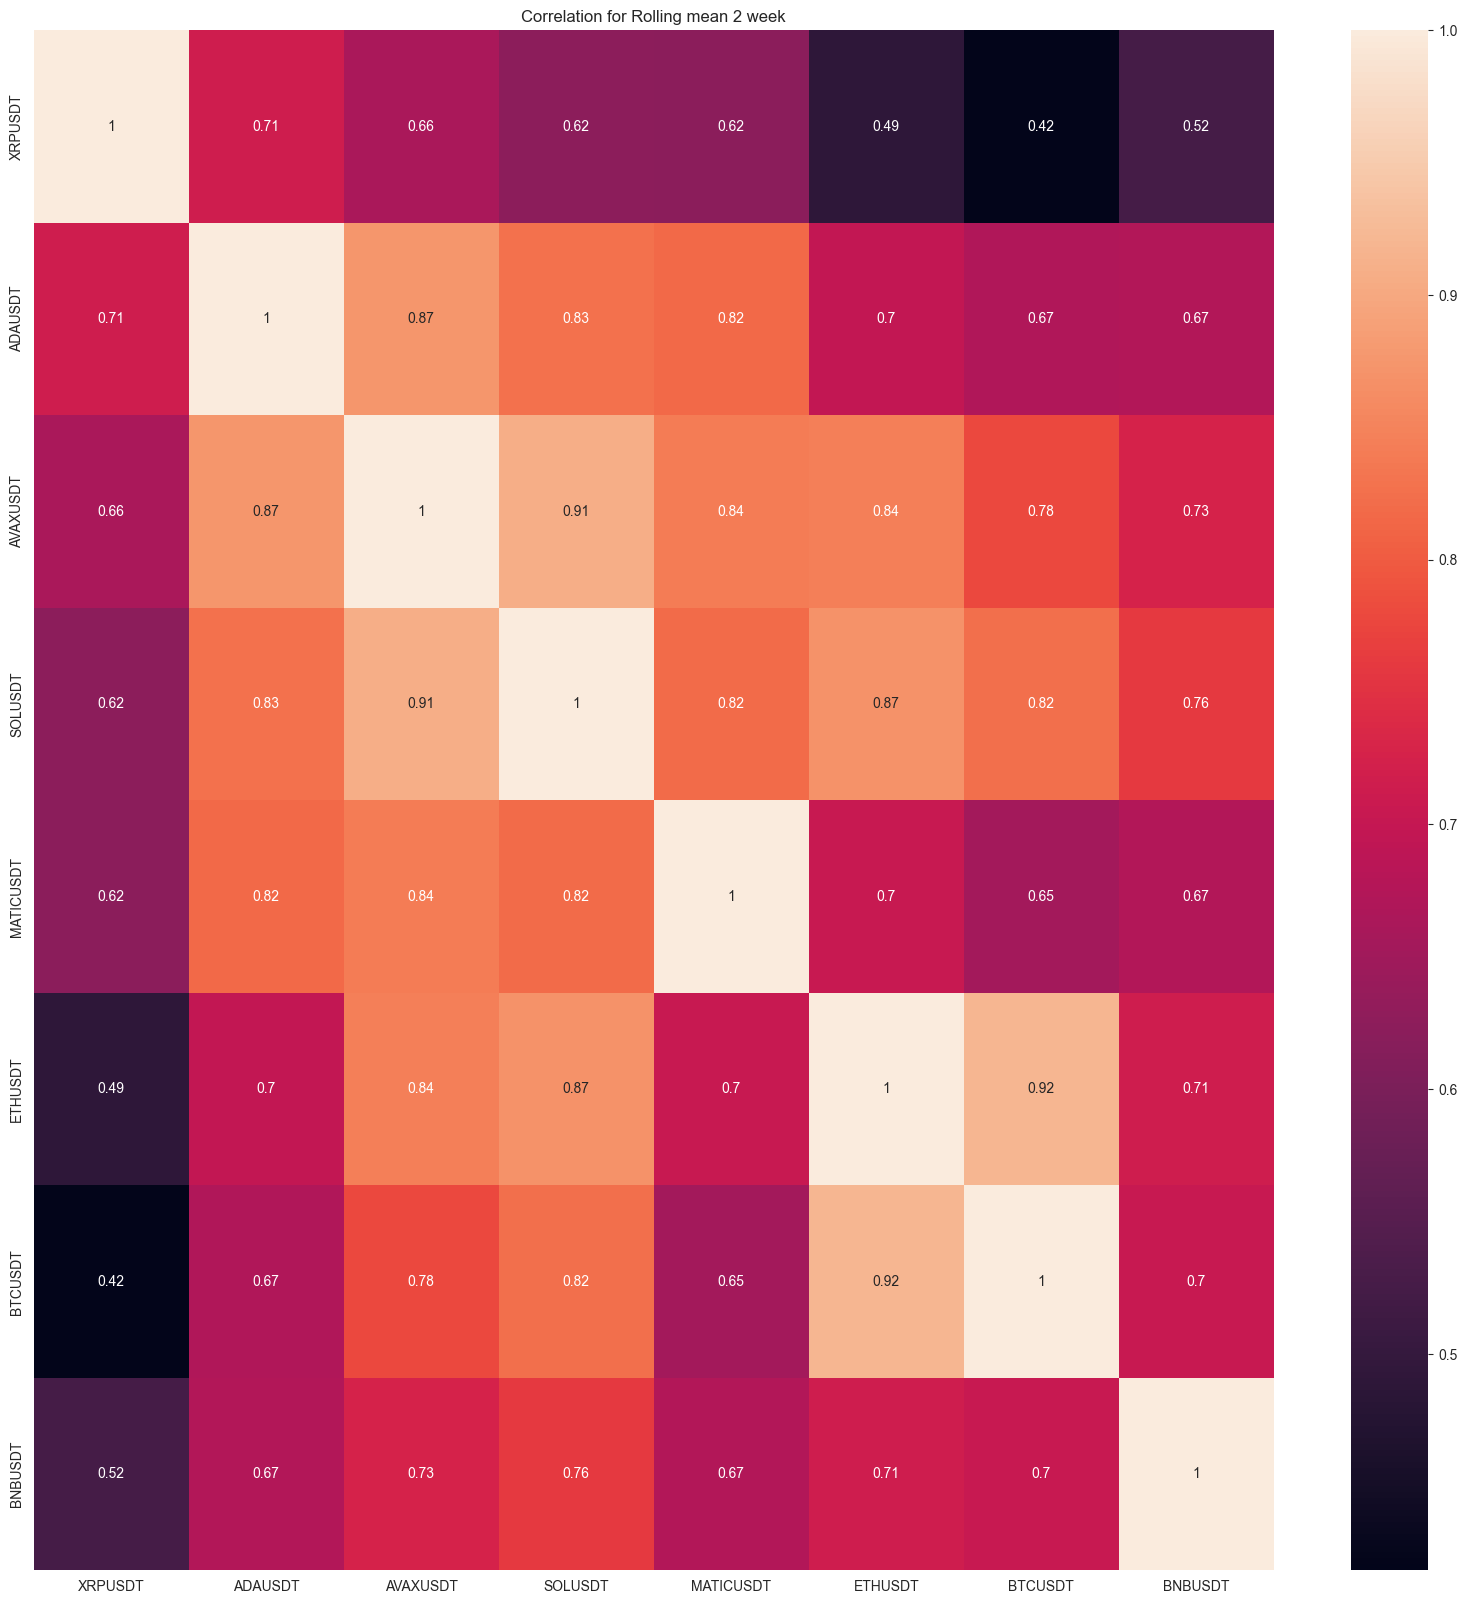

In [38]:
corrMatrixtwoweek = two_week_corr[coinlist].loc[coinlist]
fig = plt.figure(figsize=(20,20))
sn.heatmap(corrMatrixtwoweek, annot=True)
plt.title('Correlation for Rolling mean 2 week')
plt.show()

## Notes on correlation
For the Reverse Greedy Strategy you would like to see good long/mid-term correlation (a high number for the week and two-week) and a slightly lower correlation value for the daily. This implies you have a strong general trend but with noise to allow trading.

In [39]:
print(f"Day Correlation avg: {corrMatrixday.values[np.triu_indices_from(corrMatrixday.values,1)].mean()}")
print(f"Week Correlation avg: {corrMatrixweek.values[np.triu_indices_from(corrMatrixweek.values,1)].mean()}")
print(f"Two Week Correlation avg: {corrMatrixtwoweek.values[np.triu_indices_from(corrMatrixtwoweek.values,1)].mean()}")

Day Correlation avg: 0.6639156594977181
Week Correlation avg: 0.7585775680778248
Two Week Correlation avg: 0.7268382203161281


## Trade Volume

A coin that trades less frequently is more likely to suffer from slippage (a difficulty in transacting away from a position in time to make profit) You should consider this when accepting a coin list

This script identifies if any of the coins in your list trade under 5million USD in the previous 24 hour period

In [40]:
volumedata = client.get_ticker()

for data in volumedata:
    if data['symbol'] in coinlist:
        usdtradevol = float(data['volume'])*float(data['weightedAvgPrice'])
        print(data['symbol'] ,' 24hr trade volume is ' , usdtradevol,'USD')
        if usdtradevol<5E+6:
            print('Warning, low trade volumes can increase the probability of slippage')

BTCUSDT  24hr trade volume is  5074441852.221437 USD
ETHUSDT  24hr trade volume is  669159209.9997035 USD
BNBUSDT  24hr trade volume is  62798980.81807898 USD
ADAUSDT  24hr trade volume is  35633721.95514262 USD
XRPUSDT  24hr trade volume is  167644758.16241327 USD
MATICUSDT  24hr trade volume is  37114259.90572558 USD
SOLUSDT  24hr trade volume is  57365301.19203533 USD
AVAXUSDT  24hr trade volume is  15384314.285162633 USD
